In [26]:
import pickle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

## functions

In [27]:
class RemoveCorrelationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, correlation_threshold=0.7):
        self.correlation_threshold = correlation_threshold


    def fit(self, X, Y=None):
        df = pd.DataFrame(X)
        df_corr = df.corr(method='pearson', min_periods=1)
        df_not_correlated = ~(df_corr.mask(
            np.tril(np.ones([len(df_corr)] * 2, dtype=bool))).abs() > self.correlation_threshold).any()
        self.un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
        return self

    def transform(self, X, Y=None):
        df = pd.DataFrame(X)
        df = df[self.un_corr_idx]
        return df.values

In [28]:
def refactor_labels(df):
    return df.replace({'low': 0 ,'high': 1, 'clinical': 1 })


def get_data(file_name, LSAS_threshold=None):
    group_column = 'group'
    sub_num_col = 'Subject_Number'
    lsas_col = 'LSAS'
    df = pd.read_excel(file_name, sheet_name='Sheet1')
    if LSAS_threshold is None:
        X = df.drop([group_column, sub_num_col, lsas_col], 1)
        Y = refactor_labels(df[group_column])
        return X, Y
    else:
        X = df.drop([group_column], 1)
        Y = pd.Series(np.where(X[lsas_col] > LSAS_threshold, 1, 0))
        X = X.drop([sub_num_col, lsas_col], 1)
        return X, Y


## the model
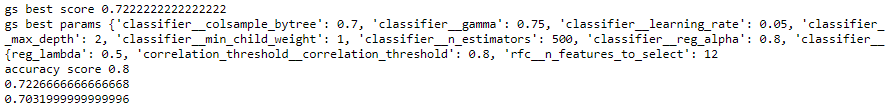

## threshold 50

In [29]:
test = pd.read_excel("test set cutoff 30.xlsx")
file_name = "training set cutoff 30.xlsx"
X_full_training_set, y_full_training_set = get_data(file_name, LSAS_threshold = 50)
random.seed(217828)
columns_shuffled = list(X_full_training_set.columns)
random.shuffle(columns_shuffled)
X_full_training_set = X_full_training_set[columns_shuffled] 
X_test = test[columns_shuffled]

In [33]:
pipe =  Pipeline([
    ('scaling', MinMaxScaler()),
    ('correlation_threshold', RemoveCorrelationTransformer(correlation_threshold = 0.9)), 
    ('rfc', RFE(RandomForestClassifier(n_estimators = 100), n_features_to_select = 13)),
    ('classifier',GradientBoostingClassifier(n_estimators=500, learning_rate=0.2, max_depth=7, min_samples_split=7))])

In [34]:
model = pipe.fit(X_full_training_set, y_full_training_set)
y_pred = model.predict(X_test)
for i in  zip(test['Subject_Number'], y_pred):
    print(i)

(5009, 1)
(5022, 0)
(5032, 0)
(5033, 1)
(5035, 0)
(5036, 0)
(5037, 1)
(5039, 0)
(5042, 0)
(5043, 0)
(5044, 0)
(5045, 1)
(5046, 0)
(5047, 0)
(5049, 1)
(5050, 0)
(5052, 1)
(5053, 0)
(5054, 1)
(8039, 1)
(203, 0)
(304, 1)
(312, 0)
(314, 0)
(315, 1)
(345, 1)
(9004, 1)
(9027, 1)


In [35]:
sum(y_pred)

13

## threshold 63

In [270]:
test = pd.read_excel("test_set_updated.xlsx")
file_name = "training_set_100_updated.xlsx"
X_full_training_set, y_full_training_set = get_data(file_name, LSAS_threshold = 63)
random.seed(217828)
columns_shuffled = list(X_full_training_set.columns)
random.shuffle(columns_shuffled)
X_full_training_set = X_full_training_set[columns_shuffled] 
X_test = test[columns_shuffled]

In [271]:
pipe =  Pipeline([
    ('scaling', MinMaxScaler()),
    #('correlation_threshold', RemoveCorrelationTransformer(correlation_threshold = 0.8)), 
    
    ('SMOTE', RandomUnderSampler()),
    ('rfc', RFE(RandomForestClassifier(n_estimators = 100), n_features_to_select = 15)),
    ('classifier',RandomForestClassifier(max_depth=20, n_estimators=100))])

In [272]:
model = pipe.fit(X_full_training_set, y_full_training_set)
y_pred = model.predict(X_test)
for i in zip (test['Subject_Number'], y_pred):
    print(i)

(8039, 0)
(5009, 0)
(5022, 0)
(5030, 0)
(5031, 1)
(5032, 0)
(5033, 1)
(5035, 0)
(5036, 1)
(5037, 0)
(5039, 0)
(5042, 0)
(5043, 0)
(5044, 0)
(5045, 1)
(5046, 0)
(5047, 0)
(5049, 0)
(5050, 0)
(5052, 0)
(5053, 0)
(5054, 0)
(203, 0)
(304, 1)
(312, 0)
(314, 0)
(315, 1)
(345, 1)
(9004, 1)
(9027, 1)


In [273]:
sum(y_pred
   )

9